In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 2
setup_one_gpu(GPU)

Picking GPU 2


In [2]:
import sys
import time
import numpy as np
import os
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from general_tools.notebook.tf import reset_tf_graph

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets

from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
import tf_lab.point_clouds.encoders_decoders as enc_dec

from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id

from tf_lab.autopredictors.plotting import plot_original_pclouds_vs_reconstructed, \
                                           plot_train_val_test_curves, plot_reconstructions_at_epoch, \
                                           plot_interpolations

from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs
                                                  
from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k
from geo_tool import Point_Cloud

from tf_lab.point_clouds.gan import model_saver_id
from tf_lab.nips.shape_net import pc_loader as sn_pc_loader
from tf_lab.autopredictors.exploration import latent_embedding_of_entire_dataset
from tf_lab.point_clouds.raw_gan import RawGAN
from tf_lab.point_clouds.raw_wgan import RawWGAN

from general_tools.notebook.tf import reset_tf_graph

/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/geo_tool/solids/mesh.py:26: UserWarning: Mayavi library was not found. Some graphics utilities will be disabled.
  warnings.warn('Mayavi library was not found. Some graphics utilities will be disabled.')


In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
n_pc_samples = 2048
do_training = True
do_plotting = True
save_model = True
save_synthetics_sample = False
seed = 42

class_name = raw_input('Give me the class type.\n').lower()
syn_id = shape_net_category_to_synth_id()[class_name]
synthetic_data_out_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/NIPS/our_samples/'
experiment_name = 'raw_w_gan_' + class_name +'_' + str(n_pc_samples) +  '_pts'

Give me the class type.
chair


In [5]:
init_lr = None
max_epochs = 400
clamp = None
batch_size = 50
noise_params = {'mu':0, 'sigma': 1}

In [6]:
top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
train_dir = osp.join(top_data_dir, 'OUT/models/nips/gan/raw_wgan')
train_dir = osp.join(train_dir, experiment_name)
create_dir(train_dir)

full_pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Core/from_manifold_meshes/centered/', str(n_pc_samples))
full_pclouds_path = osp.join(full_pclouds_path, syn_id)
full_file_names = pio.load_filenames_of_input_data(full_pclouds_path, '.ply')
full_pclouds, full_model_ids, full_syn_ids = pio.load_crude_point_clouds(file_names=full_file_names,\
                                                                           n_threads=50, loader=sn_pc_loader)
print '%d files containing complete point clouds were found.' % (len(full_pclouds), )
train_data = PointCloudDataSet(full_pclouds)

6778 files containing complete point clouds were found.


In [7]:
clamp_list = [1e-2, 1e-1]
init_lr_list = [1e-3, 1e-4, 1e-5]

*==== STARTING: clamp: 0.010000, init_lr: 0.001000
1 (-6.8920606444350796e-16, -2.489249242945793e-09) 21.8677859306
INFO:tensorflow:/orions4-zfs/projects/lins2/Jingwei_Space/Git_Repos/tf_lab/notebooks/jingwei/c_0.010000_l_0.001000_/c_0.010000_l_0.001000_models.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


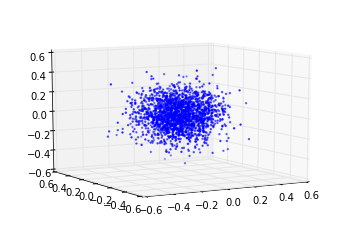

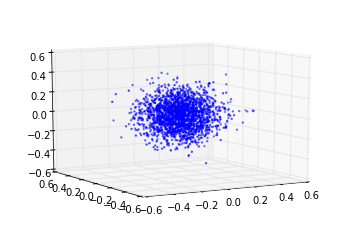

2 (-1.6974076465380172e-15, 2.4937271329387539e-07) 21.8750181198
3 (2.1053118096595562e-16, 2.4944618341275299e-07) 21.9347791672
4 (2.1053118096595562e-16, 2.4944881294720325e-07) 21.6191039085
5 (-5.4738107051148459e-15, 2.494592468725319e-07) 21.6505339146
6 (-2.3158429906255119e-15, 2.4946549333267116e-07) 21.667001009
7 (2.1053118096595562e-16, 2.4946854182417155e-07) 22.0163030624
8 (-3.3684988954552899e-15, 2.4946958605882914e-07) 22.237237215
9 (-1.6842494477276449e-15, 2.4946954921587246e-07) 21.8222079277
10 (0.0, 2.4946950816229219e-07) 22.5420560837
11 (-2.9474365335233785e-15, 2.4946950395166859e-07) 22.2615859509
12 (-6.9475289718765349e-15, 2.4946949026714183e-07) 22.1807320118
13 (-1.2631870857957337e-15, 2.4946945552949692e-07) 26.1855959892
14 (-1.6842494477276449e-15, 2.4946940079138989e-07) 36.5755848885
15 (-2.1053118096595562e-16, 2.494693376320356e-07) 26.0284121037
16 (-5.8948730670467569e-15, 2.4946935342187419e-07) 22.6961858273
17 (-1.052655904829778e-14, 2.

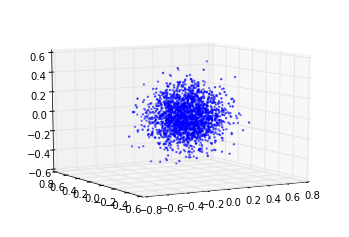

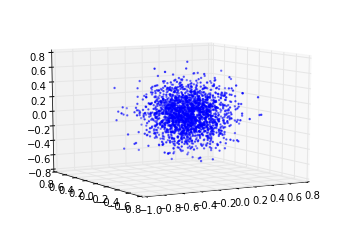

52 (-8.6317784196041799e-15, 2.4946962921772124e-07) 21.7556300163
53 (-1.6842494477276449e-15, 2.4946963132303307e-07) 23.0383989811
54 (-2.105311809659556e-15, 2.4946956500571105e-07) 22.4278068542
55 (1.4737182667616892e-15, 2.4946956500571105e-07) 21.6855590343
56 (-4.6316859812510238e-15, 2.4946958921679688e-07) 22.5802330971
57 (-1.2631870857957337e-15, 2.4947047660572465e-07) 21.8369328976
58 (-4.2106236193191124e-16, 2.494704681844774e-07) 22.4654178619
59 (-1.052655904829778e-15, 2.4947040186715537e-07) 22.2554588318
60 (1.052655904829778e-15, 2.494703871299727e-07) 22.4635739326
61 (0.0, 2.4947035870826327e-07) 21.7858700752
62 (-3.7895612573872009e-15, 2.4947036923482235e-07) 22.4063498974
63 (6.3159354289786686e-16, 2.4947051029071359e-07) 21.9476430416
64 (-2.1053118096595562e-16, 2.4947053976507893e-07) 21.6475548744
65 (-7.5791225147744019e-15, 2.4947050502743408e-07) 23.0958931446
66 (3.7895612573872009e-15, 2.4947048292166007e-07) 22.8817431927
67 (-2.3158429906255119e

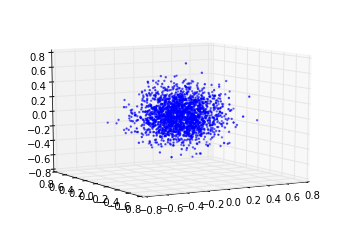

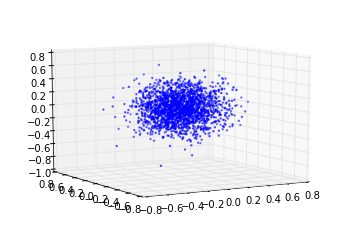

102 (-2.1053118096595562e-16, 2.4947394194896333e-07) 21.6544911861
103 (-1.6842494477276449e-15, 2.494738966847594e-07) 21.6513340473
104 (-1.1368683772161604e-14, 2.494738703683618e-07) 21.7835609913
105 (-7.368591333808446e-15, 2.4947384194665237e-07) 21.7219920158
106 (-4.2106236193191124e-16, 2.4947383878868468e-07) 21.5526251793
107 (1.2631870857957337e-15, 2.4947427774619698e-07) 21.8166000843
108 (-4.2106236193191124e-16, 2.4947433037899219e-07) 21.717674017
109 (-4.0000924383531569e-15, 2.4947427353557333e-07) 21.6578991413
110 (2.1053118096595562e-16, 2.4947423879792848e-07) 21.777739048
111 (-2.1053118096595562e-16, 2.4947422406074581e-07) 21.7095999718
112 (-8.4212472386382247e-16, 2.4947413669030574e-07) 21.808743
113 (-2.1053118096595562e-16, 2.4947412932171441e-07) 21.609637022
114 (-4.210623619319112e-15, 2.494741503748325e-07) 21.7375600338
115 (-4.2106236193191124e-16, 2.4947410616328449e-07) 21.7470579147
116 (-2.105311809659556e-15, 2.4947408089954274e-07) 21.629483

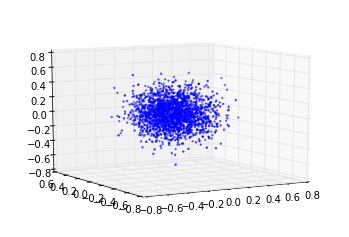

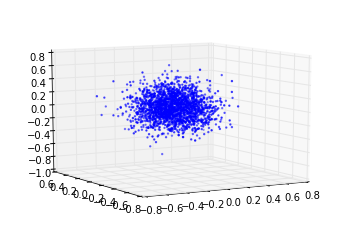

152 (0.0, 1.9943636720688152e-07) 21.6557939053
153 (-1.0316027867331826e-14, 1.9943635983829018e-07) 21.99127388
154 (-1.2631870857957337e-15, 1.99436328784941e-07) 21.7976138592
155 (-2.8421709430404009e-15, 1.9943628878401661e-07) 25.1536390781
156 (-2.3158429906255119e-15, 1.9943620088724856e-07) 27.8507871628
157 (-1.3684526762787115e-15, 1.9943618878170564e-07) 24.9014041424
158 (-8.4212472386382247e-16, 1.9943619930826469e-07) 22.2914130688
159 (-5.26327952414889e-16, 1.9943621036115169e-07) 22.4665141106
160 (1.052655904829778e-15, 1.9943615614937262e-07) 24.2257478237
161 (-1.3684526762787115e-15, 1.994361098325128e-07) 21.802284956
INFO:tensorflow:/orions4-zfs/projects/lins2/Jingwei_Space/Git_Repos/tf_lab/notebooks/jingwei/c_0.010000_l_0.001000_/c_0.010000_l_0.001000_models.ckpt-161 is not in all_model_checkpoint_paths. Manually adding it.
162 (-2.0000462191765784e-15, 1.9943609035837855e-07) 22.3301739693
163 (-3.157967714489334e-15, 1.9943603825191127e-07) 22.5895428658
164

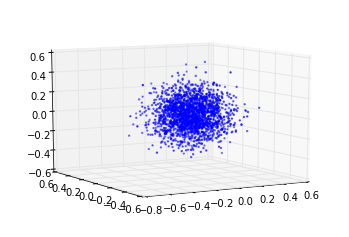

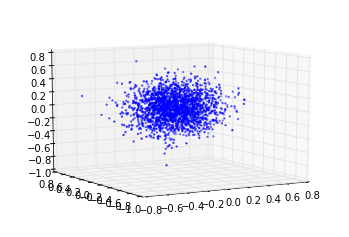

202 (-3.8948268478701789e-15, 1.9943734038726553e-07) 22.045799017
203 (1.6842494477276449e-15, 1.9943731459719588e-07) 22.1651239395
204 (-8.4212472386382247e-16, 1.9943731828149152e-07) 22.2611298561
205 (-4.2106236193191124e-16, 1.9943733775562578e-07) 22.1142380238
206 (3.4737644859382675e-15, 1.9943734143992144e-07) 22.3495597839
207 (-3.684295666904223e-15, 1.9943727617525534e-07) 22.3452808857
208 (-6.3159354289786686e-16, 1.994372877544703e-07) 22.5723559856
209 (-1.2631870857957337e-15, 1.9943724880620182e-07) 22.1397988796
210 (1.052655904829778e-15, 1.9943721827918059e-07) 21.9380128384
211 (-2.4211085811084895e-15, 1.9943722617409985e-07) 21.8602581024
212 (-4.2106236193191124e-16, 1.9943723406901915e-07) 21.9137589931
213 (8.4212472386382247e-16, 1.9943721143691721e-07) 22.3515639305
214 (5.789607476563779e-15, 1.9943719459442271e-07) 22.3728649616
215 (-1.3684526762787115e-15, 1.9943717354130462e-07) 22.15396595
216 (1.8947806286936005e-15, 1.9943714459326723e-07) 22.4291

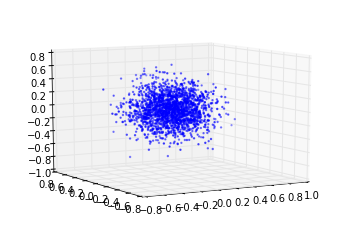

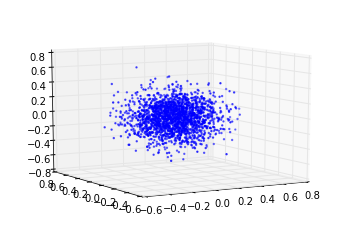

252 (-4.6316859812510238e-15, 1.9943768881637003e-07) 21.9071090221
253 (-1.1895011724576492e-14, 1.9943769723761728e-07) 21.7632551193
254 (-5.26327952414889e-16, 1.994376793424669e-07) 22.0238318443
255 (-4.8422171622169789e-15, 1.9943769197433774e-07) 22.1376609802
256 (-1.4737182667616892e-15, 1.994377035535527e-07) 21.6660461426
257 (-3.2632333049723119e-15, 1.9943768355309052e-07) 22.3704237938
258 (5.26327952414889e-16, 1.9943766302630036e-07) 21.9790120125
259 (-1.0526559048297781e-16, 1.9943766986856376e-07) 21.6139349937
260 (5.26327952414889e-16, 1.9943769934292908e-07) 21.8359460831
261 (-3.8948268478701789e-15, 1.9943766144731651e-07) 21.6364870071
262 (-1.578983857244667e-15, 1.9943767144754761e-07) 21.8241360188
263 (-3.4737644859382675e-15, 1.9943762407803188e-07) 21.7958209515
264 (-1.157921495312756e-15, 1.9943762513068779e-07) 22.027310133
265 (-1.157921495312756e-15, 1.9943754933946264e-07) 21.6444430351
266 (-7.3685913338084462e-16, 1.9943757618218822e-07) 21.75721

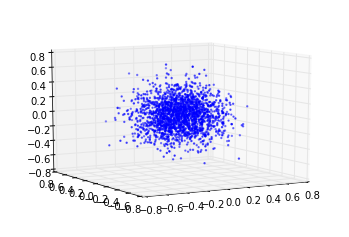

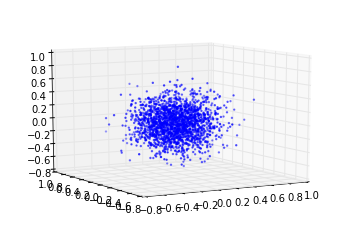

302 (-1.157921495312756e-15, 1.9943862462746944e-07) 21.6614480019
303 (-2.3158429906255119e-15, 1.9943864304894778e-07) 21.7470159531
304 (1.3684526762787115e-15, 1.9943865568081862e-07) 22.0624940395
305 (0.0, 1.9943865989144225e-07) 22.1888551712
306 (-8.4212472386382247e-16, 1.9943882726373112e-07) 21.827393055
307 (0.0, 1.9943897200391802e-07) 21.8091681004
308 (-5.789607476563779e-15, 1.9943899937297154e-07) 21.6624550819
309 (-7.263325743325468e-15, 1.9943897042493416e-07) 22.0629870892
310 (-1.3684526762787115e-15, 1.9943899042539636e-07) 22.1712069511
311 (-1.157921495312756e-15, 1.9943900621523492e-07) 21.7725410461
312 (-1.0000231095882892e-14, 1.9943899253070816e-07) 21.9379508495
313 (-5.26327952414889e-15, 1.9943897568821369e-07) 21.9364550114
314 (3.684295666904223e-15, 1.9943896831962236e-07) 21.7918307781
315 (-2.1053118096595562e-16, 1.994392067461848e-07) 21.765955925
316 (-2.7369053525574229e-15, 1.9943935359168354e-07) 21.7119569778
317 (-6.6317322004276018e-15, 1.

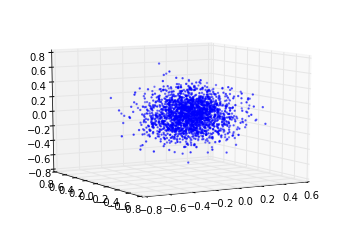

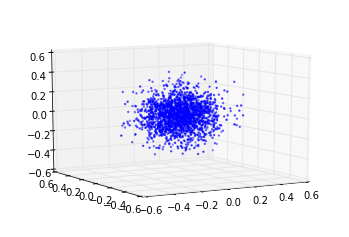

352 (-3.8948268478701789e-15, 1.9943946569953739e-07) 21.8323049545
353 (-4.2106236193191124e-16, 1.9943948096304802e-07) 21.8470780849
354 (-6.315935428978668e-15, 1.9943952306928421e-07) 22.0615727901
355 (-1.0526559048297781e-16, 1.9943948359468777e-07) 21.907212019
356 (-5.1580139336659128e-15, 1.9943944727805905e-07) 21.9122190475
357 (-1.0526559048297781e-16, 1.9943943043556458e-07) 21.9516448975
358 (-1.578983857244667e-15, 1.9943941938267758e-07) 21.9721460342
359 (-1.052655904829778e-15, 1.9943939096096815e-07) 21.8417329788
360 (-3.1579677144893343e-16, 1.9943935464433942e-07) 21.7225859165
361 (-3.1579677144893343e-16, 1.9943932306466228e-07) 22.1579639912
INFO:tensorflow:/orions4-zfs/projects/lins2/Jingwei_Space/Git_Repos/tf_lab/notebooks/jingwei/c_0.010000_l_0.001000_/c_0.010000_l_0.001000_models.ckpt-361 is not in all_model_checkpoint_paths. Manually adding it.
362 (-8.1054504671892917e-15, 1.9943928674803356e-07) 21.6578860283
363 (-9.6844343244339579e-15, 1.994392809584

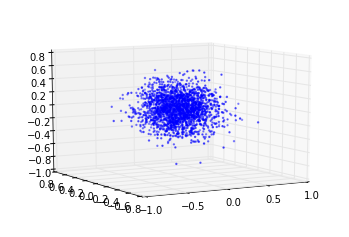

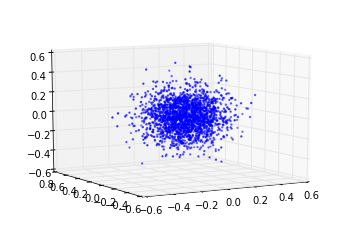

2 (-4.5395785895784175e-16, 1.1901694395454065e-08) 21.6222410202
3 (-3.9474596431116675e-16, 2.0523936657186654e-08) 22.1296029091
4 (-2.7763799489885395e-15, 2.0524170149424543e-08) 22.0604410172
5 (-3.0527021240063564e-15, 2.0524215808374418e-08) 22.1539428234
6 (-2.3684757858670005e-15, 2.0524247651215538e-08) 21.8454608917
7 (-1.5921420560550392e-15, 2.0524283836262265e-08) 22.1115829945
8 (9.8686491077791697e-16, 2.0524312850090643e-08) 22.040394783
9 (1.052655904829778e-15, 2.0524313047463626e-08) 21.8653228283
10 (2.1184700084699284e-15, 2.0524320218681979e-08) 21.8946790695
11 (0.0, 2.0524321797665834e-08) 21.8168940544
12 (0.0, 2.0524321797665834e-08) 22.1088731289
13 (1.4474018691409449e-16, 2.0524321797665834e-08) 22.011275053
14 (1.4474018691409449e-16, 2.0524321797665834e-08) 22.0624198914
15 (9.8686491077791697e-16, 2.0524324955633549e-08) 21.9682328701
16 (1.1973960917438725e-15, 2.0524335745356575e-08) 21.7221961021
17 (-1.9474134239350894e-15, 2.0524353179969996e-08) 

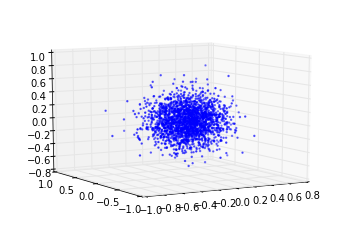

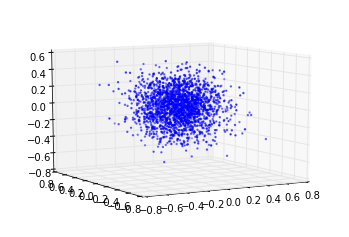

52 (-6.9738453694972798e-16, 2.0526194077774562e-08) 21.6374740601
53 (-3.5132390823693844e-15, 2.0526350462967424e-08) 21.9886991978
54 (-6.3554100254097853e-15, 2.0526348291864621e-08) 22.1204431057
55 (-1.5395092608135505e-15, 2.0526342897003108e-08) 21.8195879459
56 (-8.5528292267419462e-16, 2.0526367765998859e-08) 22.0125250816
57 (1.0526559048297781e-16, 2.0526367897580849e-08) 22.2160339355
58 (-1.4474018691409449e-16, 2.0526369147609735e-08) 21.7690930367
59 (-2.1316282072803005e-15, 2.0526369937101663e-08) 22.6759479046
60 (-1.3552944774683392e-15, 2.0526369344982715e-08) 22.0288579464
61 (1.5263510620031782e-15, 2.0526368094953829e-08) 21.9531149864
62 (-1.7763568394002505e-15, 2.0526368621281782e-08) 21.9650490284
63 (-4.1316744264568789e-15, 2.0526367173879912e-08) 22.1445758343
64 (-5.552759897977079e-15, 2.0526368950236751e-08) 21.8637149334
65 (1.9737298215558339e-15, 2.0526367305461901e-08) 22.0622031689
66 (4.1185162276465065e-15, 2.0526364147494186e-08) 21.7650821209


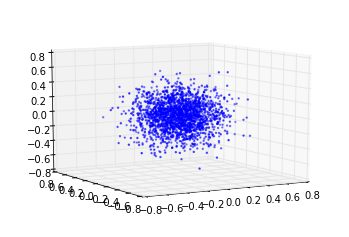

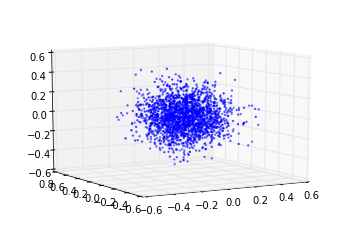

102 (-2.750063551367795e-15, 2.0526823829169627e-08) 22.0590741634
103 (-1.6053002548654115e-15, 2.0526831460924937e-08) 22.3141849041
104 (9.079157179156835e-16, 2.0526941858212955e-08) 22.5486609936
105 (2.0921536108491839e-15, 2.0526966661417712e-08) 21.8797180653
106 (2.0263626167973229e-15, 2.0526966661417712e-08) 22.0580999851
107 (1.0000231095882892e-15, 2.052696725353666e-08) 21.8469500542
108 (-3.3948152930760344e-15, 2.0527029426026039e-08) 21.9548890591
109 (-1.3684526762787114e-14, 2.0527041136822981e-08) 21.9198150635
110 (-1.2973984027027015e-14, 2.0527032781366734e-08) 22.0984358788
111 (-4.2764146133709734e-15, 2.0527022320598681e-08) 21.99812603
112 (-3.5658718776108734e-15, 2.0527021860061723e-08) 22.2769238949
113 (-4.6580023788717679e-15, 2.0527021794270728e-08) 22.0694820881
114 (-6.1317206456334569e-15, 2.0527020281077867e-08) 22.4074928761
115 (-4.0264088359739009e-15, 2.0527018965257986e-08) 22.2794559002
116 (-2.2368937977632784e-15, 2.0527018438930033e-08) 22.

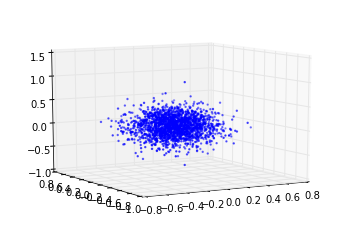

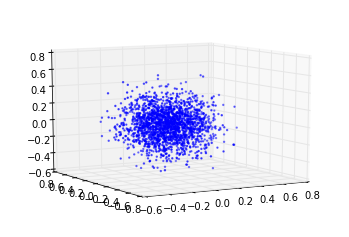

152 (1.3158198810372225e-16, 2.0527018307348044e-08) 22.1469480991
153 (-3.631662871662734e-15, 2.052701791260208e-08) 22.0957899094
154 (-6.8948961766350459e-15, 2.0527018438930033e-08) 22.1026329994
155 (-9.2896883601227909e-15, 2.0527017846811085e-08) 22.5036218166
156 (-5.1053811384244238e-15, 2.0527015544126293e-08) 22.3006179333
157 (-4.8948499574584679e-15, 2.0527016202036235e-08) 22.0403859615
158 (-5.3553869158214955e-15, 2.0527016794155179e-08) 22.0650169849
159 (-3.210600509730823e-15, 2.0527018307348044e-08) 21.887789011
160 (-1.4210854715202005e-15, 2.0527019096839972e-08) 21.9075639248
161 (-2.1316282072803005e-15, 2.0527020675823831e-08) 21.9268329144
INFO:tensorflow:/orions4-zfs/projects/lins2/Jingwei_Space/Git_Repos/tf_lab/notebooks/jingwei/c_0.010000_l_0.000100_/c_0.010000_l_0.000100_models.ckpt-161 is not in all_model_checkpoint_paths. Manually adding it.
162 (-2.8948037382818895e-15, 2.0527021267942775e-08) 22.088903904
163 (-3.0527021240063564e-15, 2.05270213337337

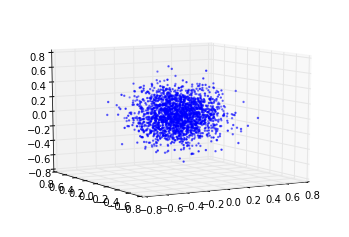

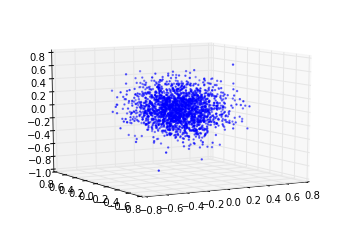

202 (6.5790994051861125e-17, 2.0527021860061723e-08) 22.5162258148
203 (2.6711143585055619e-15, 2.0527021794270728e-08) 23.2124090195
204 (-2.6316397620744452e-17, 2.0527022189016692e-08) 23.0114920139
205 (9.2107391672605575e-16, 2.0527020412659853e-08) 22.8374941349
206 (2.3816339846773729e-15, 2.0527018965257986e-08) 22.5453689098
207 (-6.5790994051861125e-17, 2.0527020610032836e-08) 22.4107840061
208 (-1.3289780798475947e-15, 2.0527023899582537e-08) 23.1906850338
209 (-5.5132853015459624e-15, 2.0527024952238443e-08) 23.0057070255
210 (-2.1711028037114174e-15, 2.0527025346984407e-08) 22.8358180523
211 (-5.6053926932185679e-15, 2.0527024820656454e-08) 22.6675040722
212 (-7.7896536957403578e-15, 2.0527025610148385e-08) 22.4488999844
213 (-7.0396363635491404e-15, 2.0527024952238443e-08) 22.5760760307
214 (-7.5001733219121686e-16, 2.0527021465315759e-08) 22.7280790806
215 (2.6316397620744452e-17, 2.0527014754634365e-08) 22.4242680073
216 (-1.3158198810372226e-17, 2.0527014754634365e-08)

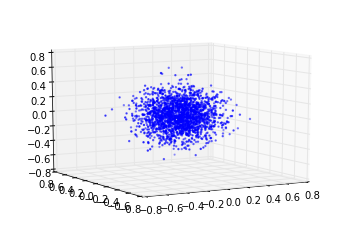

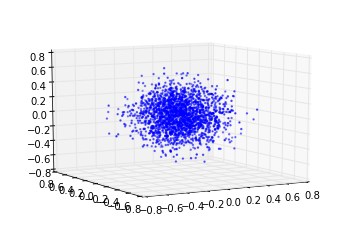

252 (0.0, 2.0527021860061723e-08) 22.1996171474
253 (0.0, 2.0527021860061723e-08) 22.5379271507
254 (9.4739031434680023e-16, 2.0527020741614825e-08) 22.297041893
255 (3.4869226847486399e-15, 2.0527018307348044e-08) 22.4080591202
256 (3.5527136788005009e-15, 2.0527018307348044e-08) 22.4050500393
257 (3.5527136788005009e-15, 2.0527018307348044e-08) 22.3710570335
258 (3.5527136788005009e-15, 2.0527018307348044e-08) 22.7798650265
259 (2.513215972781095e-15, 2.0527018307348044e-08) 23.2899200916
260 (0.0, 2.0527018307348044e-08) 23.0666251183
261 (1.276345284606106e-15, 2.0527018307348044e-08) 23.1144239902
262 (3.3816570942656619e-15, 2.0527018438930033e-08) 22.6461629868
263 (3.3027079014034285e-15, 2.0527018570512019e-08) 22.807806015
264 (5.9211894646675012e-16, 2.0527021531106753e-08) 22.5659930706
265 (1.3158198810372226e-17, 2.0527021860061723e-08) 23.2105619907
266 (-2.6316397620744452e-17, 2.0527021860061723e-08) 22.6031110287
267 (-1.7237240441587615e-15, 2.0527023570627568e-08) 2

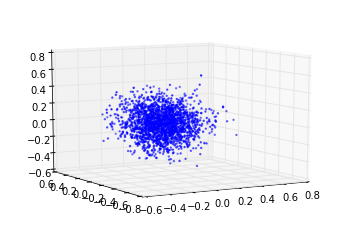

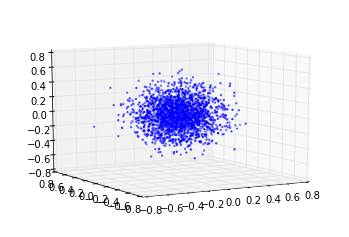

302 (-5.9211894646675012e-16, 2.0527141139133937e-08) 22.6420679092
303 (-2.9869111299544954e-15, 2.0527140744387973e-08) 22.2602329254
304 (-2.052679014418067e-15, 2.0527139165404118e-08) 22.4523210526
305 (-2.4211085811084895e-15, 2.0527137783793242e-08) 22.5310618877
306 (-1.513192863192806e-15, 2.0527136533764356e-08) 22.7392289639
307 (-4.4211548002850679e-15, 2.0527136402182367e-08) 22.9648270607
308 (-1.4737182667616892e-15, 2.0527135086362486e-08) 22.5516300201
309 (1.1842378929335003e-16, 2.0527135349526461e-08) 23.1684410572
310 (-2.8948037382818899e-16, 2.0527136139018392e-08) 22.5206401348
311 (-3.1184931180582174e-15, 2.0527138244330201e-08) 23.0940790176
312 (-4.684318776492512e-15, 2.0527139560150082e-08) 22.5715968609
313 (-3.8948268478701789e-15, 2.0527142652326802e-08) 22.4055149555
314 (-4.9343245538895844e-15, 2.0527144231310658e-08) 22.1968829632
315 (-3.0000693287648674e-15, 2.0527141928625869e-08) 23.1412100792
316 (-1.868464231072856e-15, 2.0527142125998849e-08)

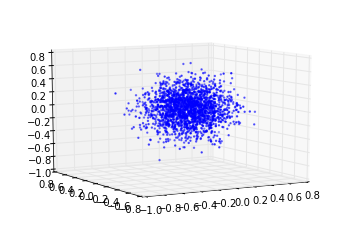

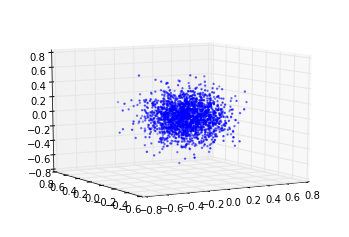

352 (-2.3816339846773729e-15, 2.0527120612343796e-08) 22.3748099804
353 (-2.9869111299544954e-15, 2.052712100708976e-08) 22.3289270401
354 (-3.4079734918864064e-15, 2.0527120941298765e-08) 22.8503110409
355 (-7.3817495326188192e-15, 2.0527121336044729e-08) 22.4177410603
356 (-5.8817148682363845e-15, 2.0527120546552801e-08) 22.9635288715
357 (-3.5132390823693844e-15, 2.052712120446274e-08) 22.4286749363
358 (-3.4079734918864064e-15, 2.0527121401835724e-08) 22.492454052
359 (-3.5921882752316175e-15, 2.0527121336044729e-08) 22.5748329163
360 (-1.0263395072090335e-15, 2.0527121599208704e-08) 22.2013430595
361 (-1.8289896346417394e-15, 2.0527123243983558e-08) 22.163410902
INFO:tensorflow:/orions4-zfs/projects/lins2/Jingwei_Space/Git_Repos/tf_lab/notebooks/jingwei/c_0.010000_l_0.000100_/c_0.010000_l_0.000100_models.ckpt-361 is not in all_model_checkpoint_paths. Manually adding it.
362 (-2.7763799489885395e-15, 2.0527124888758408e-08) 22.7463932037
363 (-2.3158429906255119e-15, 2.052712488875

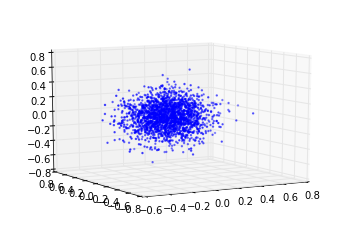

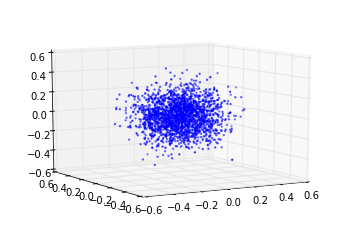

2 (-2.3462713253744974e-15, 9.3523554127398991e-09) 21.9071478844
3 (-2.5526905692122119e-15, 3.220301128639794e-08) 22.1816790104
4 (-1.1842378929335002e-15, 3.220319629067321e-08) 22.2184090614
5 (-3.868510450249434e-15, 3.2203234186285788e-08) 22.6517510414
6 (-2.1053118096595562e-16, 3.2203268792348659e-08) 22.9157450199
7 (-2.6316397620744452e-17, 3.2203315767118411e-08) 22.7275538445
8 (-1.1342367374540859e-14, 3.2203356031206767e-08) 22.1849439144
9 (-4.0000924383531569e-15, 3.2203391032015605e-08) 22.7053160667
10 (1.9737298215558339e-15, 3.2203400111172786e-08) 22.2079610825
11 (3.6053464740419899e-15, 3.2203417085249252e-08) 22.3672499657
12 (-7.3685913338084462e-16, 3.2203431296103967e-08) 22.6546158791
13 (-1.2368706881749892e-15, 3.2203448007016455e-08) 22.5034840107
14 (-2.7895381477989119e-15, 3.2203461033633275e-08) 22.5016191006
15 (-7.1054273576010019e-15, 3.2203473665504134e-08) 22.2571148872
16 (-6.6317322004276018e-15, 3.2203473402340156e-08) 22.0898170471
17 (-3.2

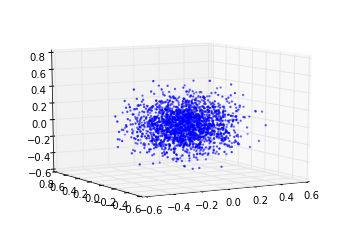

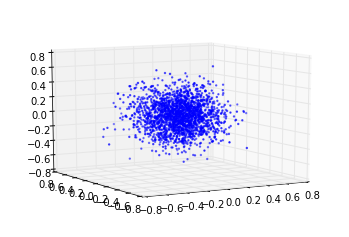

52 (0.0, 3.220351629806828e-08) 21.9021730423
53 (0.0, 3.220351629806828e-08) 22.0042319298
54 (0.0, 3.220351629806828e-08) 21.8262720108
55 (0.0, 3.220351629806828e-08) 21.9644629955
56 (0.0, 3.220351629806828e-08) 21.8795080185
57 (0.0, 3.220351629806828e-08) 21.8023710251
58 (0.0, 3.220351629806828e-08) 21.8333799839
59 (0.0, 3.220351629806828e-08) 21.795938015
60 (0.0, 3.220351629806828e-08) 21.8077180386
61 (0.0, 3.220351629806828e-08) 21.8111000061
62 (0.0, 3.220351629806828e-08) 21.8437728882
63 (0.0, 3.220351629806828e-08) 21.6076691151
64 (0.0, 3.220351629806828e-08) 21.8995511532
65 (0.0, 3.220351629806828e-08) 21.8157069683
66 (0.0, 3.220351629806828e-08) 21.8035099506
67 (0.0, 3.220351629806828e-08) 22.05707407
68 (0.0, 3.220351629806828e-08) 21.8736319542
69 (0.0, 3.220351629806828e-08) 22.1194200516
70 (0.0, 3.220351629806828e-08) 21.807500124
71 (0.0, 3.220351629806828e-08) 21.8185229301
72 (0.0, 3.220351629806828e-08) 21.8945248127
73 (-7.8949192862233357e-17, 3.2203516

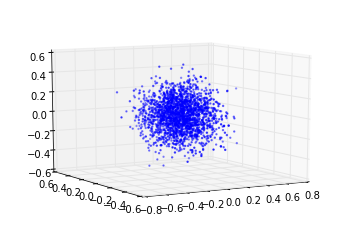

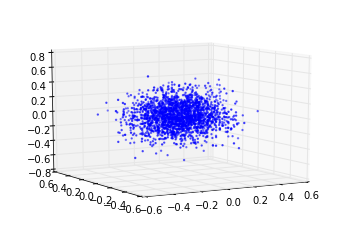

102 (1.3158198810372225e-16, 3.2203543667121804e-08) 22.7179410458
103 (0.0, 3.220354471977771e-08) 22.2301299572
104 (0.0, 3.220354471977771e-08) 22.374560833
105 (0.0, 3.220354471977771e-08) 21.8394880295
106 (0.0, 3.220354471977771e-08) 22.3745748997
107 (0.0, 3.220354471977771e-08) 22.0970938206
108 (0.0, 3.220354471977771e-08) 21.8524339199
109 (0.0, 3.220354471977771e-08) 22.5507159233
110 (-7.8949192862233357e-17, 3.2203551298877118e-08) 22.0030870438
111 (-3.4211316906967787e-16, 3.2203551825205068e-08) 22.7246799469
112 (-4.4737875955265563e-16, 3.2203551825205068e-08) 22.1715300083
113 (-9.2107391672605575e-16, 3.2203551825205068e-08) 22.4243280888
114 (-1.4737182667616892e-15, 3.2203551825205068e-08) 22.3587441444
115 (-1.7105658453483892e-15, 3.2203551825205068e-08) 22.0497169495
116 (-2.1316282072803005e-15, 3.2203551825205068e-08) 21.9878618717
117 (-3.6053464740419899e-15, 3.2203551825205068e-08) 22.4624159336
118 (-4.500103993147301e-15, 3.2203551825205068e-08) 21.82701

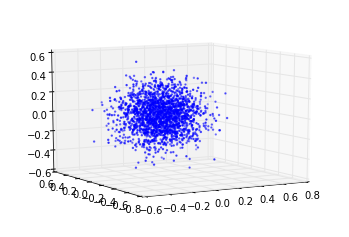

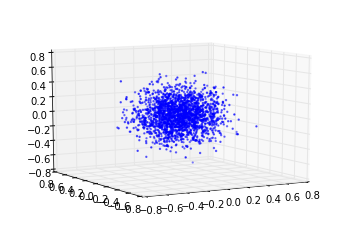

152 (-1.0763406626884481e-14, 3.2203555509500736e-08) 21.7866609097
153 (-1.105288700071267e-14, 3.2203555772664714e-08) 21.7666938305
154 (-8.131766864810035e-15, 3.2203556298992664e-08) 22.1213719845
155 (0.0, 3.2203559062214415e-08) 21.8619329929
156 (0.0, 3.2203558930632425e-08) 22.1235899925
157 (0.0, 3.2203558930632425e-08) 21.9632930756
158 (0.0, 3.2203558930632425e-08) 22.1727671623
159 (0.0, 3.2203558930632425e-08) 22.0832881927
160 (0.0, 3.2203558930632425e-08) 22.1228749752
161 (0.0, 3.2203558930632425e-08) 21.9974651337
INFO:tensorflow:/orions4-zfs/projects/lins2/Jingwei_Space/Git_Repos/tf_lab/notebooks/jingwei/c_0.010000_l_0.000010_/c_0.010000_l_0.000010_models.ckpt-161 is not in all_model_checkpoint_paths. Manually adding it.
162 (0.0, 3.2203558930632425e-08) 21.7960751057
163 (0.0, 3.2203558930632425e-08) 21.9775259495
164 (0.0, 3.2203558930632425e-08) 22.1002640724
165 (0.0, 3.2203558930632425e-08) 22.1919820309
166 (0.0, 3.2203558930632425e-08) 22.0991139412
167 (0.0, 

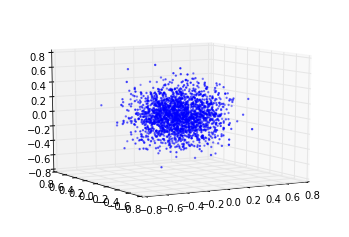

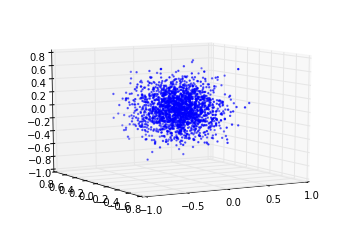

202 (0.0, 3.2203558930632425e-08) 21.5456950665
203 (0.0, 3.2203558930632425e-08) 22.1979739666
204 (0.0, 3.2203558930632425e-08) 22.6965460777
205 (0.0, 3.2203558930632425e-08) 22.0815548897
206 (0.0, 3.2203558930632425e-08) 22.1793308258
207 (0.0, 3.2203558930632425e-08) 21.9415659904
208 (0.0, 3.2203558930632425e-08) 22.0958151817
209 (0.0, 3.2203558930632425e-08) 21.9637401104
210 (0.0, 3.2203558930632425e-08) 21.7239170074
211 (0.0, 3.2203558930632425e-08) 21.8690769672
212 (0.0, 3.2203558930632425e-08) 21.7852060795
213 (0.0, 3.2203558930632425e-08) 21.9202661514
214 (0.0, 3.2203558930632425e-08) 21.8197009563
215 (0.0, 3.2203558930632425e-08) 21.6833920479
216 (0.0, 3.2203558930632425e-08) 21.8994479179
217 (0.0, 3.2203558930632425e-08) 21.7914178371
218 (0.0, 3.2203558930632425e-08) 21.8895421028
219 (0.0, 3.2203558930632425e-08) 22.3599991798
220 (-1.3158198810372225e-15, 3.2203566299223761e-08) 21.995486021
221 (-1.342136278657967e-15, 3.220356643080575e-08) 21.8309321404
222

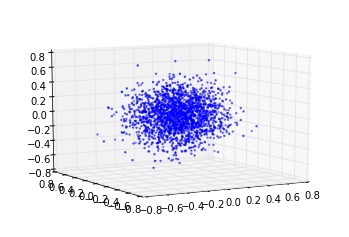

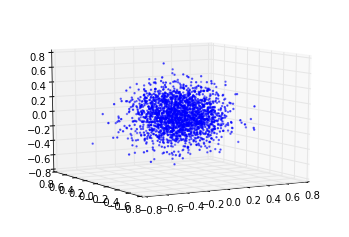

252 (3.5527136788005009e-15, 3.2203562614928093e-08) 21.9799349308
253 (3.5263972811797564e-15, 3.2203562483346104e-08) 22.1373288631
254 (3.500080883559012e-15, 3.2203562483346104e-08) 21.8141989708
255 (3.5263972811797564e-15, 3.2203562483346104e-08) 21.9510858059
256 (3.5527136788005009e-15, 3.2203562483346104e-08) 22.304407835
257 (3.5527136788005009e-15, 3.2203562483346104e-08) 21.9811580181
258 (3.5527136788005009e-15, 3.2203562483346104e-08) 22.008587122
259 (3.5263972811797564e-15, 3.2203562483346104e-08) 22.1113669872
260 (3.5527136788005009e-15, 3.2203562483346104e-08) 21.9710359573
261 (3.5527136788005009e-15, 3.2203562483346104e-08) 22.0970580578
262 (3.5527136788005009e-15, 3.2203562483346104e-08) 22.1366388798
263 (3.5527136788005009e-15, 3.2203562483346104e-08) 22.1803929806
264 (3.5527136788005009e-15, 3.2203562483346104e-08) 22.1503169537
265 (3.5527136788005009e-15, 3.2203562483346104e-08) 22.1173238754
266 (3.5527136788005009e-15, 3.2203562483346104e-08) 21.941491842

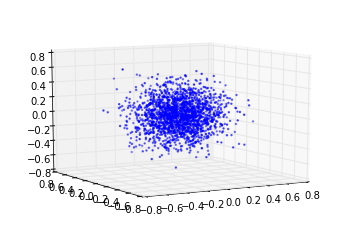

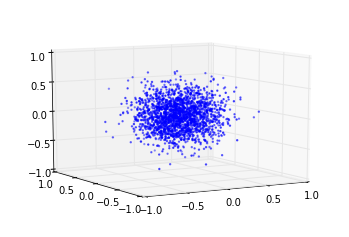

302 (-2.394792183487745e-15, 3.2203564983403877e-08) 21.7350509167
303 (-2.1842610025217895e-15, 3.2203565641313816e-08) 22.0397171974
304 (-2.0000462191765784e-15, 3.2203564983403877e-08) 21.9591488838
305 (-1.342136278657967e-15, 3.2203564325493938e-08) 22.289796114
306 (-1.2105542905542447e-15, 3.2203563667583999e-08) 22.3846609592
307 (-1.7631986405898782e-15, 3.2203563930747971e-08) 21.9882059097
308 (-1.394769073899456e-15, 3.2203563141256043e-08) 21.70992589
309 (-2.1316282072803005e-15, 3.2203563009674054e-08) 21.8343348503
310 (-3.3948152930760344e-15, 3.220356353600201e-08) 22.046049118
311 (-3.5527136788005009e-15, 3.2203563009674054e-08) 22.0382931232
312 (-3.9474596431116679e-15, 3.2203562878092072e-08) 21.8457798958
313 (-3.9474596431116679e-15, 3.2203563272838032e-08) 21.9163098335
314 (-3.9474596431116679e-15, 3.2203563141256043e-08) 21.8878598213
315 (-3.973776040732412e-15, 3.2203563141256043e-08) 22.0978839397
316 (-3.6579792692834789e-15, 3.2203563141256043e-08) 21.

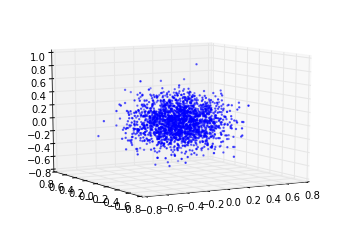

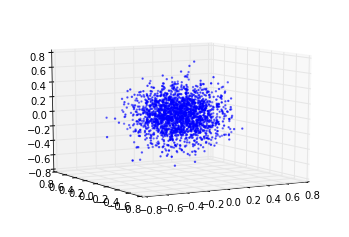

352 (-2.1842610025217895e-15, 3.220356116752622e-08) 21.7526810169
353 (-2.1316282072803005e-15, 3.2203561299108209e-08) 21.7219479084
354 (-1.921097026314345e-15, 3.2203560509616281e-08) 21.643155098
355 (-1.921097026314345e-15, 3.220356064119827e-08) 21.8837909698
356 (-1.9737298215558339e-15, 3.220356116752622e-08) 21.8320159912
357 (-1.7368822429691337e-15, 3.220356116752622e-08) 21.7014629841
358 (-1.6842494477276449e-15, 3.2203560509616281e-08) 21.5727260113
359 (-1.815831435831367e-15, 3.2203560904362248e-08) 21.7607269287
360 (-1.6579330501069005e-15, 3.2203560509616281e-08) 21.7909491062
361 (-1.868464231072856e-15, 3.2203560509616281e-08) 21.6374280453
INFO:tensorflow:/orions4-zfs/projects/lins2/Jingwei_Space/Git_Repos/tf_lab/notebooks/jingwei/c_0.010000_l_0.000010_/c_0.010000_l_0.000010_models.ckpt-361 is not in all_model_checkpoint_paths. Manually adding it.
362 (-1.6053002548654115e-15, 3.2203560772780259e-08) 21.6374089718
363 (-1.815831435831367e-15, 3.220356024645231e-0

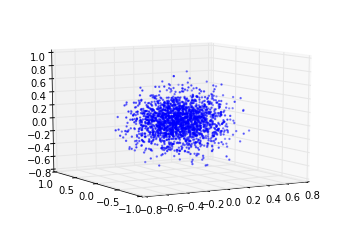

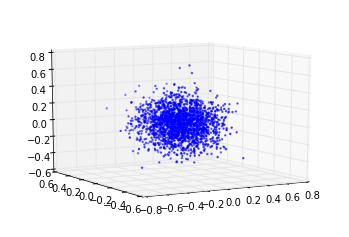

2 (-5.0575282700635772e-06, -0.0020645333635103372) 21.6518249512
3 (-1.4161295688676613e-05, -0.0015217077689831731) 21.8573358059
4 (-3.4530514434057598e-05, 0.00048848968697678139) 21.9059329033
5 (-0.00012027534949420779, 0.0051750198041123369) 21.9187910557
6 (-0.0010890332016128081, 0.019790518701214482) 22.1286349297
7 (-0.014368938157955806, 0.13794149168663555) 21.7842078209
8 (-0.0017402931357975359, 0.054818877930908151) 21.7247169018
9 (-1.9666566341011613e-06, -0.02795811856372489) 21.759665966
10 (1.9756456216176352e-06, -0.033019664386908211) 21.9089689255
11 (-8.1705274405302826e-07, -0.032856170501973897) 21.8866980076
12 (-4.3603005232634364e-06, -0.034149644137532624) 21.8912601471
13 (-3.5158165351108271e-05, -0.01512392037720592) 22.191108942
14 (-8.6419422317434238e-05, 0.025755651157211373) 22.1788759232
15 (-9.6691096270525893e-05, 0.047111838228172727) 21.9160809517
16 (-0.00023359057528001291, 0.044353571478967312) 21.8796329498
17 (-0.00027516608436902362, 0.

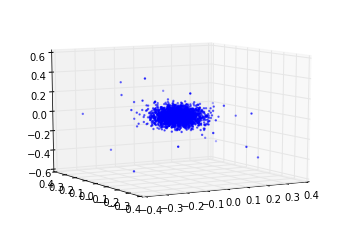

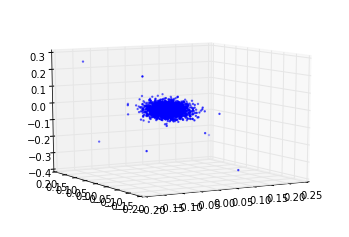

52 (-1.7249942929656417e-05, -0.077120511068238154) 21.7869920731
53 (-1.6047032894911588e-05, -0.043666022243323152) 22.4463570118
54 (-1.8691961412076596e-05, -0.043549479709731206) 21.7964711189
55 (-8.5779362254672582e-06, -0.043019850358918858) 21.8491828442
56 (-1.3055100485130592e-05, -0.043024157070451312) 21.7699270248
57 (-1.5802598661846586e-05, -0.044074589179621801) 21.6242640018
58 (-4.9272897066893399e-06, -0.045520744251984137) 21.5316159725
59 (-3.3584457856637459e-06, -0.045675598636821461) 21.6826059818
60 (-4.9507728329411263e-06, -0.044644475949031336) 21.5924649239
61 (-5.1490686557911058e-06, -0.046901387059026294) 21.5698540211
62 (-8.4831758781715677e-07, -0.045430208797808048) 21.613558054
63 (-3.5855781148981167e-06, -0.042030986950353337) 21.8301589489
64 (-8.1961905514752428e-07, -0.044590850533158692) 21.9457371235
65 (-4.3309673115059178e-06, -0.045191785389626468) 21.9806509018
66 (-2.2317524309511536e-06, -0.045776949160628848) 21.6418640614
67 (-2.3067

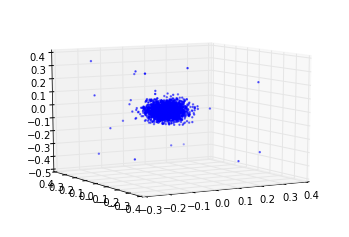

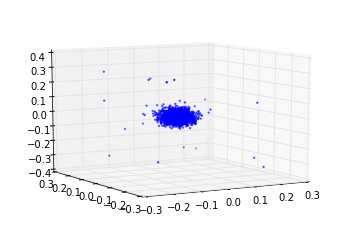

102 (-1.2342466248406304e-05, -0.040514969991313085) 22.0480320454
103 (-1.2850706224088316e-05, -0.039987714754210577) 22.0916781425
104 (-1.415359201254668e-05, -0.039724551003288339) 22.0898900032
105 (-1.4166920273392289e-05, -0.039663211546010442) 22.2226719856
106 (-9.6625751919216582e-06, -0.039397624217801623) 21.8640329838
107 (-1.1577264026359276e-05, -0.039740806376492535) 22.0711598396
108 (-1.6280870746683192e-05, -0.040805081043530395) 21.6342520714
109 (-1.939656557860198e-05, -0.041267151219977274) 21.5761430264
110 (-2.2219507782547562e-05, -0.042790579713053174) 21.585381031
111 (-1.4549907710817126e-05, -0.04342195474439197) 21.5962660313
112 (-1.6127388786386562e-05, -0.043519219452584232) 21.6583111286
113 (-7.319284809960259e-06, -0.044632189803653292) 21.5846998692
114 (-1.0950421845471417e-05, -0.044449253628651299) 21.6241791248
115 (4.6511215192300305e-06, -0.047226793926071237) 21.8946259022
116 (1.0958700268356889e-06, -0.047729563657884243) 21.9913640022
11

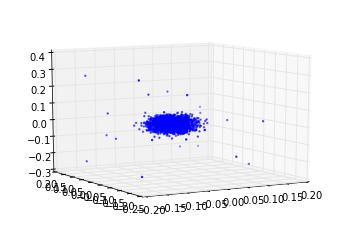

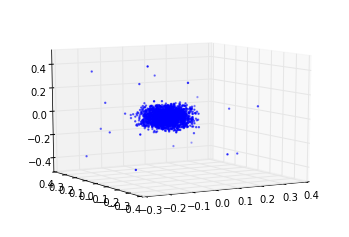

152 (2.0510344593613236e-06, -0.05647986547814475) 22.1539428234
153 (2.3231462196067529e-06, -0.055579810368793982) 22.2186210155
154 (6.9226931642602994e-07, -0.05584083373347918) 22.3563489914
155 (-1.4901713088706688e-06, -0.054226333758345353) 22.3385658264
156 (-4.9958350481810395e-06, -0.053961153107660788) 22.605768919
157 (-5.3519728007139981e-06, -0.050230643125595872) 22.2541968822
158 (-4.8942036098904082e-06, -0.043324815316332713) 22.1915538311
159 (-1.2619075951752839e-07, -0.044806532285831591) 22.2548151016
160 (-3.7625432014465332e-07, -0.045010897986314913) 22.0301480293
161 (-5.7650936974419489e-07, -0.043279315034548439) 22.3150000572
INFO:tensorflow:/orions4-zfs/projects/lins2/Jingwei_Space/Git_Repos/tf_lab/notebooks/jingwei/c_0.100000_l_0.001000_/c_0.100000_l_0.001000_models.ckpt-161 is not in all_model_checkpoint_paths. Manually adding it.
162 (-4.1149832584239819e-06, -0.042559887524004338) 21.9524581432
163 (-1.3731778771788986e-05, -0.040545484120095218) 22.2

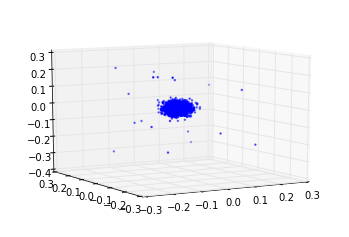

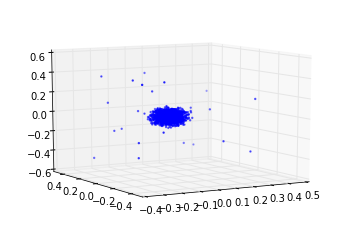

202 (-5.2909056345621744e-06, -0.23789239867969794) 22.2778539658
203 (-5.5810919514408814e-06, -0.2390708459748162) 22.1566879749
204 (2.6402650056061921e-07, -0.23376282994393949) 22.1710991859
205 (-4.0517912970648869e-06, -0.23304842743608686) 22.2390179634
206 (1.3455196663185401e-06, -0.22442359394497341) 22.7329199314
207 (3.6093923780653211e-07, -0.22211775570004075) 22.0885748863
208 (1.2130649001510055e-07, -0.22120709275757824) 22.3156609535
209 (-9.8711914486355245e-07, -0.22117064838056211) 22.1832180023
210 (-3.6879822059913917e-06, -0.23500245643986595) 22.3193759918
211 (-6.8960366425690827e-06, -0.23787462159439368) 22.0877869129
212 (-6.6040842621414747e-06, -0.23839875890149009) 22.178812027
213 (-5.5921298486215096e-06, -0.23833017382356855) 22.6924340725
214 (-5.0978528128729922e-06, -0.238321159724836) 22.1326980591
215 (-4.258641490229854e-06, -0.23864344866187484) 22.0141050816
216 (-4.4194636521516024e-06, -0.23903089927302468) 22.1305909157
217 (-4.90789060239

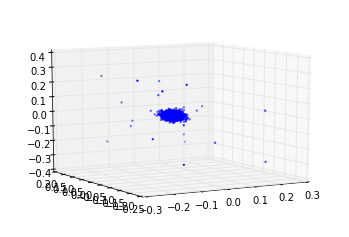

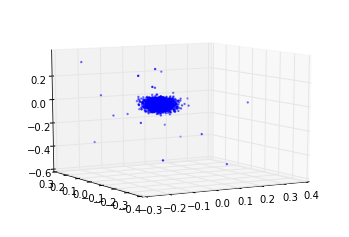

252 (-1.8819614692970559e-07, -0.23341614173518288) 22.1709969044
253 (-8.3888018572771993e-08, -0.23488143803896727) 21.8401880264
254 (7.6713385405363857e-08, -0.23357612225744459) 22.5243377686
255 (1.5022578062834562e-07, -0.2328098863363266) 21.855494976
256 (1.0232130686442057e-07, -0.23234620911103707) 22.4116990566
257 (8.0907786334002459e-08, -0.23183758391274345) 22.024533987
258 (2.8930328510425708e-07, -0.22909092461621319) 22.2077629566
259 (1.4680403250235098e-08, -0.22945559797463594) 21.9662530422
260 (4.5067734188503688e-07, -0.22715887924035391) 21.8553450108
261 (2.5111216085928457e-07, -0.22444311225855793) 21.9528720379
262 (1.1876777366355614e-07, -0.22357589061613437) 21.9378859997
263 (1.1909891057897498e-07, -0.22250513842812292) 21.9538249969
264 (7.1525573730468747e-08, -0.22153987873483588) 21.913424015
265 (-1.7450915442572699e-07, -0.22440825568305123) 21.8560700417
266 (5.5520622818558303e-08, -0.22227565226731477) 21.8726680279
267 (3.0398368835449217e-0

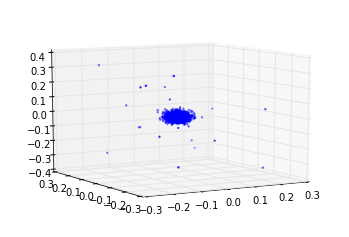

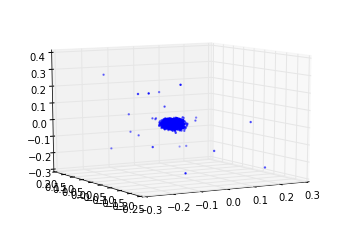

302 (2.0265579223632812e-07, -0.20318402074001454) 21.8756868839
303 (1.6115329883716725e-07, -0.20311279705277197) 22.1114702225
304 (3.4912868782326028e-07, -0.20037676173227806) 22.1911861897
305 (5.3202664410626447e-08, -0.19968326831305469) 21.8134160042
306 (8.0135133531358513e-08, -0.19764785799715254) 21.966960907
307 (1.2925377598515263e-07, -0.19785644224396459) 22.0593411922
308 (-3.7429509339509185e-07, -0.19622878951055031) 22.2645139694
309 (9.8601535514548963e-07, -0.19357712953178971) 21.940942049
310 (-1.3499348251907913e-07, -0.19224692660349388) 21.9921879768
311 (3.6016658500388817e-07, -0.19135957294040257) 22.0505650043
312 (2.5795565711127386e-07, -0.19204676647981009) 22.0841948986
313 (3.1756030188666448e-07, -0.18903314239448971) 22.1327991486
314 (-3.3665586400915073e-08, -0.18700742224852243) 21.9450330734
315 (2.0861625671386719e-07, -0.18756542272037929) 22.3805520535
316 (1.1391109890407987e-07, -0.18693734705448151) 21.8019990921
317 (2.3621099966543693e

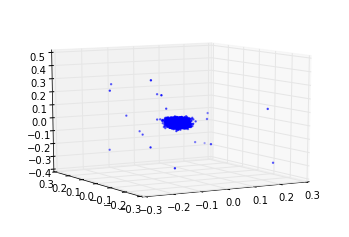

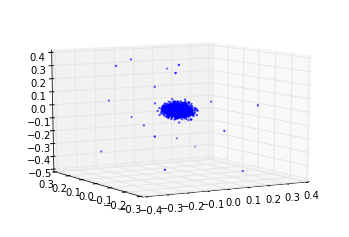

352 (-1.6894605424669054e-06, -0.23856087856822544) 21.563243866
353 (-7.3512395222981774e-07, -0.23734306019765358) 21.6472151279
354 (-5.4968727959526905e-07, -0.23767654763327706) 21.6067020893
355 (-3.5958157645331487e-06, -0.23851813983034204) 22.0017302036
356 (-2.8014183044433594e-06, -0.23909606591418939) 21.8990139961
357 (-6.7607120231345853e-07, -0.23667120933532715) 22.1891992092
358 (-1.4901161193847656e-07, -0.23239641277878373) 21.9209969044
359 (-7.9936451382107207e-07, -0.23663228639849909) 21.9820640087
360 (-7.0461520442256221e-06, -0.2376858095328013) 21.9466540813
361 (-3.0513162966127747e-06, -0.23829624553521475) 22.2837159634
INFO:tensorflow:/orions4-zfs/projects/lins2/Jingwei_Space/Git_Repos/tf_lab/notebooks/jingwei/c_0.100000_l_0.001000_/c_0.100000_l_0.001000_models.ckpt-361 is not in all_model_checkpoint_paths. Manually adding it.
362 (-1.6094357879073532e-06, -0.23795214736903156) 21.8344900608
363 (-1.8874804178873699e-06, -0.23918144956783013) 21.926756143

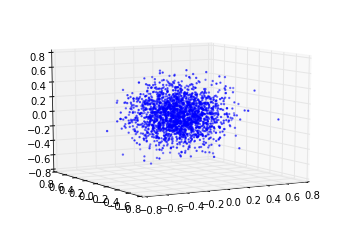

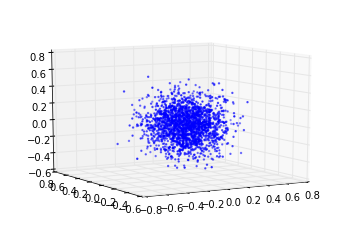

2 (-4.8058766104211961e-06, -0.00014948613076099987) 21.9191868305
3 (-8.96404785129966e-06, -7.7551333999037049e-05) 22.0868480206
4 (-1.2234100803551782e-05, -5.3029305153931661e-05) 21.6544179916
5 (-1.4150593570202882e-05, -2.712298449599378e-05) 21.6194090843
6 (-1.5513210935212018e-05, 1.7628435165938248e-05) 21.8214108944
7 (-1.7835260600636334e-05, 4.5990312274726522e-05) 21.8262560368
8 (-2.0304124848701541e-05, 7.5759571633103338e-05) 22.0007991791
9 (-2.2879169598497727e-05, 0.00010588515201730102) 21.7968599796
10 (-2.5577696861647484e-05, 0.00013970977764714648) 21.9667880535
11 (-2.8511974098229848e-05, 0.00017680539221382114) 22.1879358292
12 (-3.202185638386894e-05, 0.00021680792431450554) 21.627491951
13 (-3.5979063573500348e-05, 0.00026376888531053229) 21.6212940216
14 (-4.0274891027904774e-05, 0.00030689415008829975) 21.5893239975
15 (-4.5444349180562076e-05, 0.00036266421105850624) 21.5605669022
16 (-5.1958397186050813e-05, 0.00042698053099835914) 22.1087150574
17 (

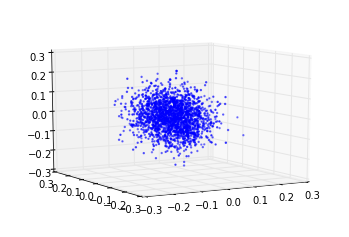

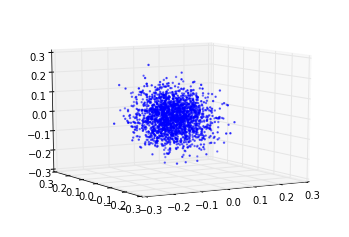

52 (8.4811372121125545e-06, -4.6543078232835559e-05) 21.824131012
53 (6.7757771359066719e-06, -0.00026855105480299917) 21.6842570305
54 (5.2276028630634153e-06, -0.00043991322228167619) 21.6554701328
55 (4.4538510135478447e-06, -0.00055839160362396525) 21.6911520958
56 (3.5933982063498761e-06, -0.00063832880523814653) 21.747879982
57 (3.1146315719794344e-06, -0.00070179030902821707) 21.6266219616
58 (2.6225664273456292e-06, -0.00075846441797222251) 21.9159560204
59 (2.2200212158538676e-06, -0.00080074742651992927) 22.0665359497
60 (1.9237899255973322e-06, -0.0007845800288056058) 21.8479290009
61 (1.7822715798737827e-06, -0.00082488665874633519) 22.0675020218
62 (1.3552019717516723e-06, -0.00085945421165821174) 21.8191449642
63 (1.0271448883469458e-06, -0.00084721493853808004) 21.8453330994
64 (8.5443327272379835e-07, -0.00086755498907425336) 22.0477588177
65 (7.4510850633184116e-07, -0.00088779652853392891) 21.8759050369
66 (5.8933704470594725e-07, -0.00090822639995840964) 22.021884918

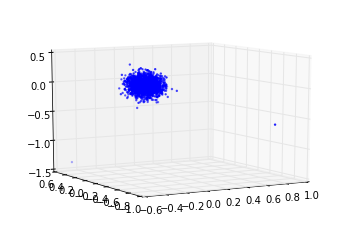

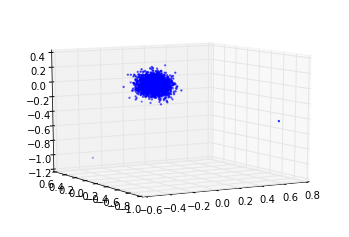

102 (-1.1825801252766892e-05, -0.0018730605090105975) 21.8009309769
103 (-1.0485179653322255e-05, -0.0019691918278113008) 21.6881489754
104 (-1.2867407942259753e-05, -0.0019988751866751248) 21.9604699612
105 (-2.5505525991320609e-05, -0.002041305492942532) 21.7535841465
106 (-2.2705663340511145e-05, -0.0020464425302903961) 22.1661849022
107 (-2.1860646773819571e-05, -0.001989647461515334) 22.0592989922
108 (-2.2419093659630527e-05, -0.00192196406337812) 22.0893540382
109 (-2.5780007450117004e-05, -0.0018351962919243509) 22.3734841347
110 (-3.3196423168259642e-05, -0.0017015772173181176) 22.0387189388
111 (-4.3650718267869068e-05, -0.0015594435390084982) 21.901296854
112 (-6.2719784263107507e-05, -0.0014262632596203023) 21.7120740414
113 (-7.6007203164475931e-05, -0.0013491672170520932) 21.7150659561
114 (-3.2671838481393122e-05, -0.0013440645480942395) 21.7579119205
115 (-2.2388356565325349e-06, -0.0012468790023208217) 21.8268671036
116 (-8.5722715421407307e-06, -0.00116278150084394) 2

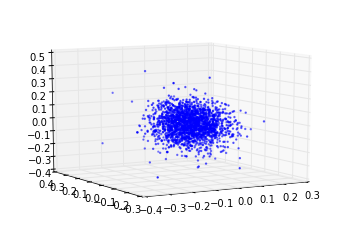

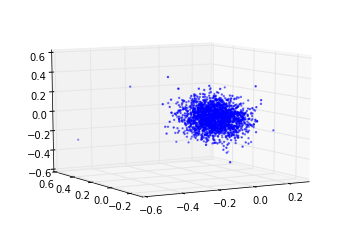

152 (-3.644786516411437e-06, -0.00096215271925622671) 22.5469191074
153 (-3.4583995498164938e-06, -0.00096389729555489286) 22.081553936
154 (-3.4121636956654213e-06, -0.00096372666949820192) 22.2940559387
155 (-3.5539916199114587e-06, -0.0009672425070743042) 22.5837249756
156 (-3.6389075426591768e-06, -0.0009706144057283247) 22.3556940556
157 (-3.7921760748657915e-06, -0.00097459777370440188) 22.3664741516
158 (-3.9554528754066537e-06, -0.00098155778013514689) 22.3225290775
159 (-4.1055846614418203e-06, -0.00098861935462250762) 22.0658769608
160 (-4.1842891800182841e-06, -0.00099291356659873776) 22.2885811329
161 (-3.9006109107975607e-06, -0.00099758844805398475) 22.3483309746
INFO:tensorflow:/orions4-zfs/projects/lins2/Jingwei_Space/Git_Repos/tf_lab/notebooks/jingwei/c_0.100000_l_0.000100_/c_0.100000_l_0.000100_models.ckpt-161 is not in all_model_checkpoint_paths. Manually adding it.
162 (-4.5246280798757522e-06, -0.0010024208049462348) 21.6751229763
163 (-4.5443962638576824e-06, -0.0

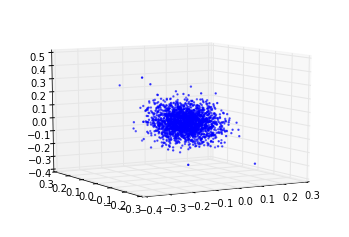

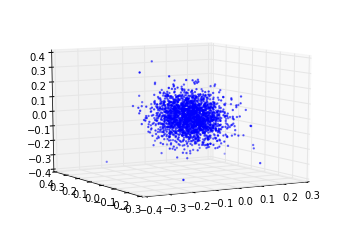

202 (-1.2202217692026385e-05, -0.0011177081226681669) 21.6116609573
203 (-1.2497974697638441e-05, -0.0011215142655634769) 21.7550401688
204 (-1.2794003339001427e-05, -0.0011303280092154939) 22.5523529053
205 (-1.2981563944507529e-05, -0.0011377990099222021) 22.4856450558
206 (-1.3264239317289105e-05, -0.0011431810713407617) 21.8259439468
207 (-1.3414381451352879e-05, -0.0011540757431821138) 22.2820689678
208 (-1.3651078808362837e-05, -0.0011620472306040702) 21.7784240246
209 (-1.3871794497525251e-05, -0.0011689898006066127) 21.8409128189
210 (-1.3965791677711186e-05, -0.0011745652149396915) 22.0375468731
211 (-1.4191608082641054e-05, -0.0011792923668744388) 22.1361749172
212 (-1.4335870811784709e-05, -0.0011852471959880656) 22.090359211
213 (-1.4429438548783461e-05, -0.0011927777539110845) 21.8746249676
214 (-1.4556069099516781e-05, -0.0012000905979355728) 22.0509440899
215 (-1.4580907817516062e-05, -0.001207226615709563) 21.8466880322
216 (-1.4732116660862057e-05, -0.00121126564961202

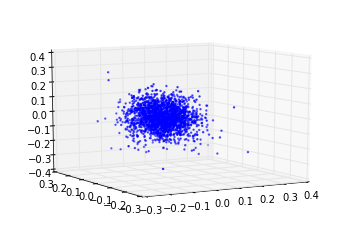

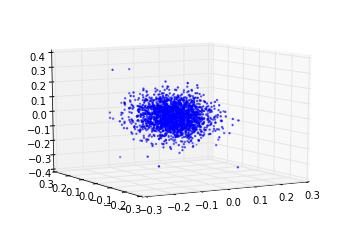

252 (-1.6563040790734469e-05, -0.0010572172080477078) 26.3500430584
253 (-1.7730486406772225e-05, -0.0010582409773228897) 27.5953829288
254 (-1.6929223029701796e-05, -0.0010562240775605595) 27.3687820435
255 (-1.7099831839678465e-05, -0.0010536029003560543) 26.373290062
256 (-1.7040234093588812e-05, -0.0010489044167722266) 28.0033838749
257 (-1.697506910810868e-05, -0.001043719869038021) 26.9398081303
258 (-1.6959537579505533e-05, -0.0010400343927796239) 27.3009519577
259 (-1.691445035652982e-05, -0.0010343354661017656) 27.499434948
260 (-1.6917222765860734e-05, -0.001028996340378567) 26.5114359856
261 (-1.7450807650608045e-05, -0.0010101681411335314) 27.4871809483
262 (-1.7677423440747791e-05, -0.00099723044506929543) 27.6295530796
263 (-1.7266123797054643e-05, -0.00099919437154851582) 27.330163002
264 (-1.7282047688409135e-05, -0.0010008780087378841) 27.7189757824
265 (-1.7149934407185624e-05, -0.0010074241371411416) 26.3433380127
266 (-1.7005032687275498e-05, -0.0010092592220408497)

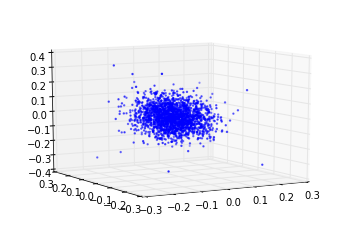

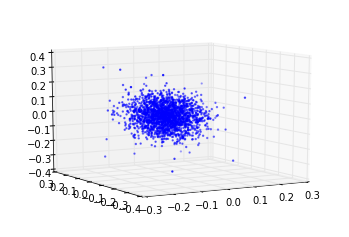

302 (-1.8221295990601733e-05, -0.0011523026171036893) 26.5384161472
303 (-1.8089861367587689e-05, -0.0011618991718730992) 27.7828788757
304 (-1.8601518779717108e-05, -0.0011360630117080829) 27.2959771156
305 (-1.8109653696969702e-05, -0.0011336624329150826) 26.586894989
306 (-1.7796053240696588e-05, -0.0011416971726618983) 28.1759779453
307 (-1.937242190319079e-05, -0.0011730250747253497) 26.7560238838
308 (-1.8120847676915151e-05, -0.0011768433593075584) 27.1625440121
309 (-1.9195295559863251e-05, -0.0011241057654842734) 27.7421491146
310 (-1.8370425742533471e-05, -0.0011322812729135708) 26.6347618103
311 (-1.9167574915896965e-05, -0.0011634678338412886) 28.0923960209
312 (-1.8896905843306472e-05, -0.0011950463780926333) 27.1187839508
313 (-1.8901046779420639e-05, -0.001185698650294432) 26.4460089207
314 (-1.9495693656305473e-05, -0.001173882840063285) 27.4638040066
315 (-1.8901609884643995e-05, -0.0011923360008815373) 26.7422411442
316 (-1.971664821246156e-05, -0.0012345629511401057)

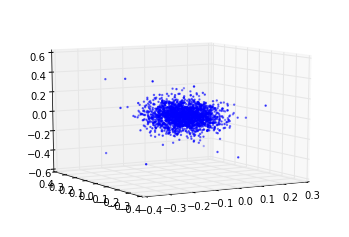

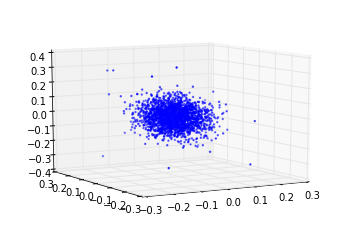

352 (-1.9530969223490468e-05, -0.004136571850351713) 26.1821620464
353 (-1.9259171353446114e-05, -0.0041444591177558455) 27.2380101681
354 (-2.030984119132713e-05, -0.004168243388886805) 27.2722351551
355 (-1.8883682787418366e-05, -0.004189686659999468) 26.19962883
356 (-2.006058477693134e-05, -0.0042315159096486038) 27.6225230694
357 (-1.9546746517773029e-05, -0.0042333314540209596) 26.7905888557
358 (-2.0232075756346738e-05, -0.0042376852490835721) 26.6584661007
359 (-1.9435829448479192e-05, -0.0042789682435492677) 27.6880512238
360 (-1.9249254492697893e-05, -0.0042742454895266782) 26.2775030136
361 (-2.0604263301248905e-05, -0.0042819753979091288) 27.0961110592
INFO:tensorflow:/orions4-zfs/projects/lins2/Jingwei_Space/Git_Repos/tf_lab/notebooks/jingwei/c_0.100000_l_0.000100_/c_0.100000_l_0.000100_models.ckpt-361 is not in all_model_checkpoint_paths. Manually adding it.
362 (-1.9642907298273512e-05, -0.004315391217392904) 26.4407229424
363 (-1.9472909884320367e-05, -0.004317236943515

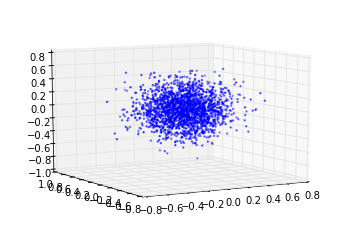

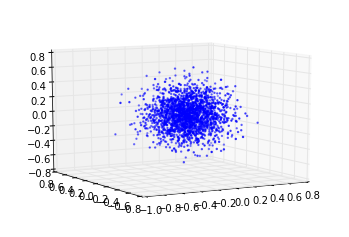

2 (-4.1751954422916576e-06, -1.9429531722313118e-05) 26.366286993
3 (-6.9349388165088987e-06, -1.8528585887570107e-05) 28.4589459896
4 (-7.5837155910213133e-06, -1.5743100010257439e-05) 26.9178030491
5 (-8.0889780562116625e-06, -1.3577292116274799e-05) 27.5649321079
6 (-8.7050493069303535e-06, -1.1324726107920503e-05) 27.672896862
7 (-9.5249553042877887e-06, -9.2172597895249194e-06) 26.8354599476
8 (-1.0679518325357801e-05, -6.2116754027859615e-06) 27.3278560638
9 (-1.1532430842096262e-05, -4.1447502823117517e-06) 27.3504588604
10 (-1.2403013803392511e-05, -1.9257093360583559e-06) 26.5728189945
11 (-1.3257567183312925e-05, 1.8252356242058982e-07) 27.6401779652
12 (-1.4014181188368066e-05, 1.5068208980479809e-06) 26.8690040112
13 (-1.4525818652247026e-05, 2.931458850610027e-06) 26.407476902
14 (-1.4946643433951841e-05, 3.9488138049313821e-06) 27.4989769459
15 (-1.5326917491620407e-05, 4.6537680073352361e-06) 26.6222541332
16 (-1.5544837845448422e-05, 5.424454684543889e-06) 26.7127392292

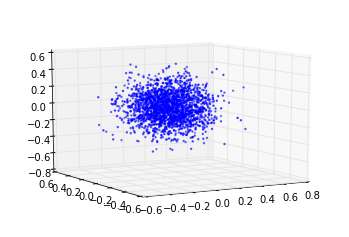

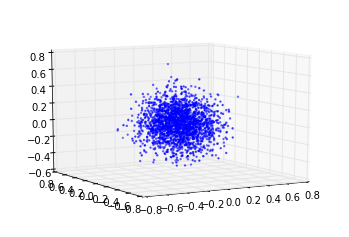

52 (-2.6387646991039489e-05, 2.072056519898103e-05) 27.7085418701
53 (-2.6719016144246174e-05, 2.2036042503680585e-05) 27.0549669266
54 (-2.7121460233401092e-05, 2.2421559724197896e-05) 26.5401010513
55 (-2.7424812665062577e-05, 2.345815792742306e-05) 27.9169070721
56 (-2.7840165448314684e-05, 2.5045086793532527e-05) 27.132712841
57 (-2.8028369261947876e-05, 2.5598133477076232e-05) 26.9919569492
58 (-2.8540206309386392e-05, 2.6598454900926703e-05) 27.8754429817
59 (-2.8876793415596087e-05, 2.7730198241813384e-05) 26.452382803
60 (-2.9272528869720797e-05, 2.5204500666910058e-05) 27.6805539131
61 (-2.9679918575480028e-05, 2.3167966665587976e-05) 27.5507121086
62 (-3.0133892680708044e-05, 2.4358219350149199e-05) 26.5837349892
63 (-3.0232728035857523e-05, 2.5346457631611782e-05) 27.4907569885
64 (-3.0837196768347726e-05, 2.6239231576457518e-05) 27.4301478863
65 (-3.1210541864210329e-05, 2.6829346232396482e-05) 27.0266599655
66 (-3.1752814053713033e-05, 2.2995034265073224e-05) 27.5767021179

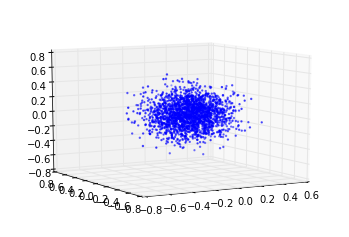

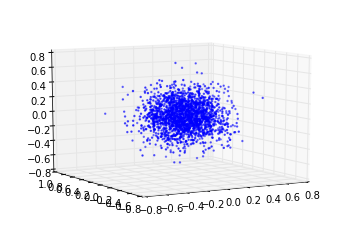

102 (-5.0476060331911195e-05, 4.7202907471391542e-05) 26.5631740093
103 (-5.1167306756488632e-05, 4.8863005994698379e-05) 28.1246109009
104 (-5.1849596315555065e-05, 4.2638503213378567e-05) 27.2940769196
105 (-5.2643424202903623e-05, 3.896257961362911e-05) 27.2144451141
106 (-5.3612207692047514e-05, 3.9868176288480218e-05) 28.0439360142
107 (-5.4135459719907008e-05, 4.1383703824572469e-05) 26.7445719242
108 (-5.4964030736031149e-05, 4.468125741739102e-05) 27.246338129
109 (-5.5577647543503661e-05, 4.6825725736130994e-05) 27.8805160522
110 (-5.6450216598696664e-05, 4.923575316853304e-05) 26.58101511
111 (-5.728609027789423e-05, 5.1389282210341967e-05) 27.6663880348
112 (-5.7920004797375036e-05, 5.3306034209931065e-05) 27.2100651264
113 (-5.8811595011286922e-05, 5.4541900209625496e-05) 26.2622878551
114 (-5.9724145615257807e-05, 5.6942971342424345e-05) 27.7973229885
115 (-6.0944326321111508e-05, 6.0190508116243611e-05) 27.3108239174
116 (-6.1601905704096514e-05, 6.2032564191785811e-05) 2

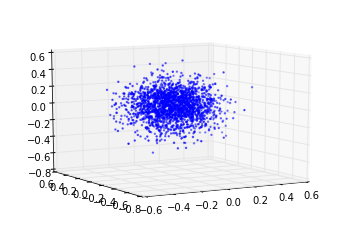

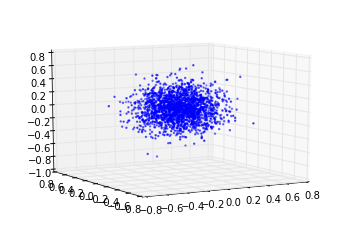

152 (-0.0001051945736873205, 9.3906726019836405e-05) 27.3385119438
153 (-0.00010729431017319223, 9.8067800367802939e-05) 26.1944880486
154 (-0.00010890086484357232, 0.00010241914127686027) 27.6971890926
155 (-0.0001096457978645857, 0.00010643481935538282) 27.3537960052
156 (-0.00011127576527306465, 0.00011057936892568789) 26.5719978809
157 (-0.00011335827811207209, 0.0001144873851983532) 28.6127281189
158 (-0.00011563897590989385, 0.00011663368651945213) 26.7847630978
159 (-0.00011700292460672143, 0.00011872050742601493) 27.3657870293
160 (-0.00011895226801883568, 0.00012176550808362663) 27.8698620796
161 (-0.0001211298754680212, 0.00012814005081222772) 26.8258919716
INFO:tensorflow:/orions4-zfs/projects/lins2/Jingwei_Space/Git_Repos/tf_lab/notebooks/jingwei/c_0.100000_l_0.000010_/c_0.100000_l_0.000010_models.ckpt-161 is not in all_model_checkpoint_paths. Manually adding it.
162 (-0.00012288015972848775, 0.00011970028680042122) 27.4445948601
163 (-0.00012376335464607649, 0.000124324349

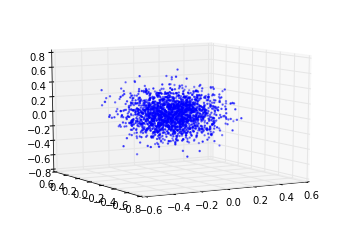

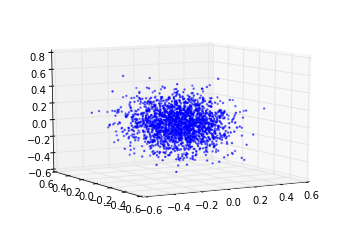

202 (-0.00022881730379864436, 0.00024819035294327749) 27.3759140968
203 (-0.00023175286618492533, 0.00024950198173798898) 26.5745530128
204 (-0.00023434553974463295, 0.00025964857950047763) 27.9280400276
205 (-0.00023741014366452065, 0.00027131705967433473) 27.2403621674
206 (-0.00023974289048325133, 0.00028037446490661414) 26.7327091694
207 (-0.00024478092662455443, 0.00028398105361567878) 28.0520861149
208 (-0.00024762199156814151, 0.00029612616075340794) 26.7804679871
209 (-0.0002543347321787021, 0.00027260744590657177) 27.3010439873
210 (-0.00025577149968335612, 0.00024311505020941022) 27.9483799934
211 (-0.00025947485248454741, 0.00026355775211144375) 26.8725781441
212 (-0.00026480951917754418, 0.00023214618273346719) 27.3003339767
213 (-0.0002673903983560632, 0.00018488610199980299) 27.8078620434
214 (-0.00027212488165349457, 0.00019649514406747012) 26.386947155
215 (-0.00027581454854010156, 0.0002080510689497546) 27.4002609253
216 (-0.00027797600045300052, 0.00022382979363168556

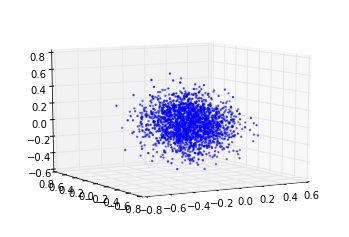

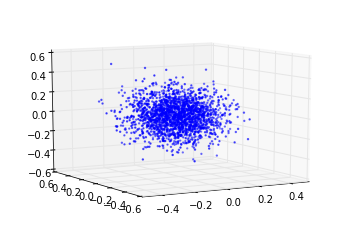

252 (-0.00042374202468501473, 0.00047317643313565187) 27.6298458576
253 (-0.00042847569307519331, 0.000485347203384326) 27.3920099735
254 (-0.00043231264722568019, 0.0005034919778592195) 26.5551249981
255 (-0.0004357810606490131, 0.00053337473353302033) 27.9763388634
256 (-0.00043983376084792393, 0.00051125097821501115) 27.1608109474
257 (-0.00044067050696833542, 0.00050915263946754513) 26.9353089333
258 (-0.00044396576984716512, 0.00052448745959231421) 28.3323578835
259 (-0.00044775032632363339, 0.00051104048745603196) 26.6998999119
260 (-0.00045111026739943084, 0.00047176741861255358) 27.4835669994
261 (-0.00045191764107180965, 0.00035124553768481646) 27.7947909832
262 (-0.00044833733894241351, 0.00040812557886561588) 26.6929900646
263 (-0.00045524515142595327, 0.00043053006003093388) 27.5480949879
264 (-0.00045831987970612115, 0.0004423246718943119) 27.388122797
265 (-0.00045577702349638223, 0.00045124495496835424) 26.7238919735
266 (-0.0004576524616115623, 0.00048036292126333273) 2

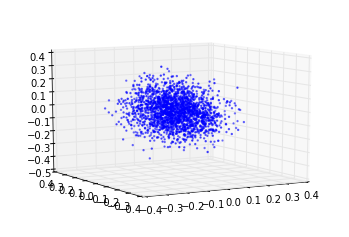

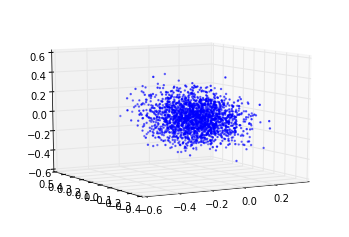

302 (-0.00037279250941032338, 0.00053249162846003418) 26.4111599922
303 (-0.0003634262574552041, 0.00054595183529373677) 27.5621910095
304 (-0.0003590496691349135, 0.00055568375952403856) 27.8245139122
305 (-0.00035048453245070519, 0.00056166402538548464) 26.2884747982
306 (-0.00034305560327117779, 0.00054693273139289685) 27.5530490875
307 (-0.00033157848045919778, 0.00054707953326955992) 27.1890079975
308 (-0.00032363338913354606, 0.00058618957538985543) 26.7983870506
309 (-0.00031863706406309373, 0.00059336414603792403) 28.3302218914
310 (-0.00030770939084942697, 0.00060658478738602115) 27.1341080666
311 (-0.00030025600227182384, 0.00060893426200857867) 27.4300820827
312 (-0.00029465680019240135, 0.00063070366633366103) 27.8711390495
313 (-0.00028169856005762185, 0.00061508713298718686) 26.6457259655
314 (-0.000272524545909147, 0.00061716510983252971) 27.2691910267
315 (-0.00026559924978452422, 0.00060422414551592537) 27.7416789532
316 (-0.00025822127074072204, 0.00060307500556249307

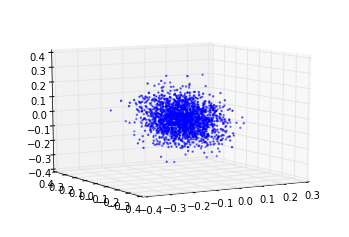

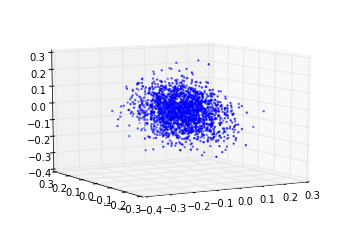

352 (2.3343984995099838e-05, 1.8331341312592417e-05) 26.837941885
353 (2.6987901249716137e-05, -1.2332156748689832e-05) 27.7956798077
354 (2.6139121921544385e-05, -4.1220517198747041e-05) 26.2926769257
355 (3.036635353055317e-05, -7.8760397930939988e-05) 27.6109499931
356 (3.0434532123359126e-05, -0.00010703680460142937) 27.280493021
357 (3.2974259455740041e-05, -0.00014736336716278283) 26.4292821884
358 (3.351315751421714e-05, -0.00016954649375596395) 27.9203491211
359 (3.5098945092478834e-05, -0.00019773415395455367) 27.207048893
360 (3.2979505259491917e-05, -0.0002304835269805389) 27.0017850399
361 (3.4189024504653556e-05, -0.00026364956984589635) 27.6586530209
INFO:tensorflow:/orions4-zfs/projects/lins2/Jingwei_Space/Git_Repos/tf_lab/notebooks/jingwei/c_0.100000_l_0.000010_/c_0.100000_l_0.000010_models.ckpt-361 is not in all_model_checkpoint_paths. Manually adding it.
362 (3.6608287417847253e-05, -0.00028594910313754725) 26.3599770069
363 (3.8291651462377224e-05, -0.000304884447595

In [9]:
# *==== STARTING: clamp: 0.100000, init_lr: 0.001000

dump_dir = '/orions4-zfs/projects/lins2/Jingwei_Space/Git_Repos/tf_lab/notebooks/jingwei'
for clamp in clamp_list:
    for init_lr in init_lr_list:
        print '*==== STARTING: clamp: %f, init_lr: %f' % (clamp, init_lr)
        reset_tf_graph()
        gan = RawWGAN(experiment_name, [n_pc_samples, 3], learning_rate=init_lr, clamp=clamp)
        if do_training:
            train_stats = []
            dump_subdir = osp.join(dump_dir, 'c_%f_l_%f_' % (clamp, init_lr))
            if not osp.exists(dump_subdir):
                os.makedirs(dump_subdir)
            for iter in range(max_epochs):
                checkpoint_path = osp.join(dump_subdir, 'c_%f_l_%f_' % (clamp, init_lr) + model_saver_id)
                loss, duration = gan._single_epoch_train(train_data, batch_size, noise_params)
                epoch = int(gan.sess.run(gan.epoch.assign_add(tf.constant(1.0))))
                print epoch, loss, duration
                if save_model:
                    if iter % 40 == 0 or iter == max_epochs - 1:
                        gan.saver.save(gan.sess, checkpoint_path, global_step=gan.epoch)
                train_stats.append((epoch,) + loss)
                if iter % 50 == 0:
                    Point_Cloud(gan.generate(1, noise_params)[0]).plot()
                    Point_Cloud(gan.generate(1, noise_params)[0]).plot()

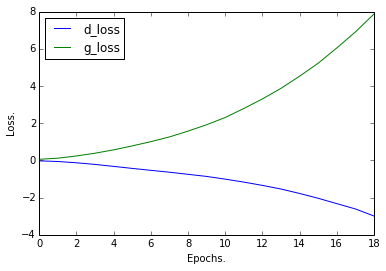

In [8]:
if do_plotting:
    x = range(len(train_stats))
    d_loss = [t[1] for t in train_stats]
    g_loss = [t[2] for t in train_stats]
    plt.plot(x, d_loss)
    plt.plot(x, g_loss)
    plt.legend(['d_loss', 'g_loss'], loc=0)
    plt.xlabel('Epochs.')
    plt.ylabel('Loss.')

In [9]:
if save_synthetics_sample:
    # Swap axis and put in U-sphere and save
    n_samples = 1000
    syn_data = gan.generate(n_samples, noise_params)
    syn_data_rot = np.empty_like(syn_data)
    for i, pc in enumerate(syn_data):
        syn_data_rot[i] = pc[:, [0, 2, 1]]
        pc = Point_Cloud(syn_data_rot[i]).center_in_unit_sphere()
        syn_data_rot[i] = pc.points
        
    save_out = osp.join(synthetic_data_out_dir, experiment_name + '_epoch_' + str(epoch))
    np.savez(save_out, syn_data_rot)

In [10]:
from tf_lab.nips.evaluate_gan import entropy_of_occupancy_grid
print entropy_of_occupancy_grid(syn_data, 32)

NameError: name 'syn_data' is not defined

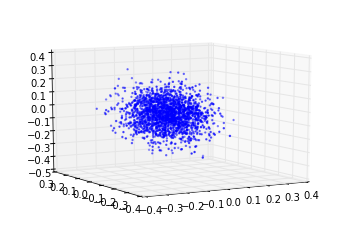

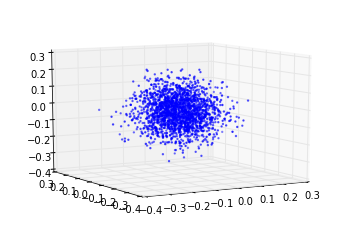

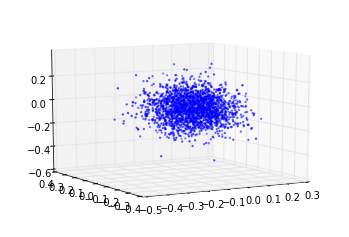

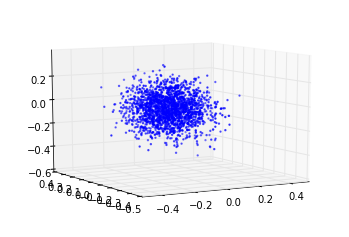

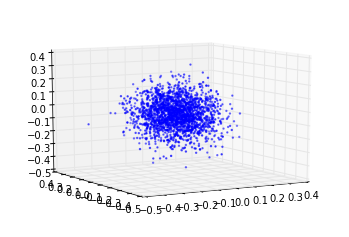

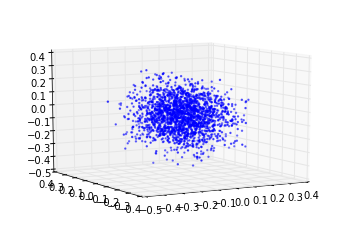

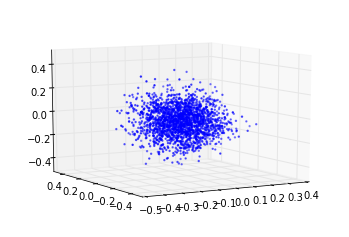

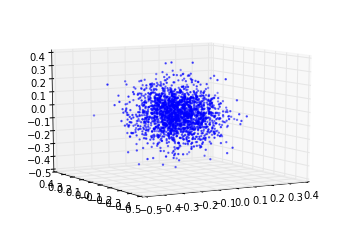

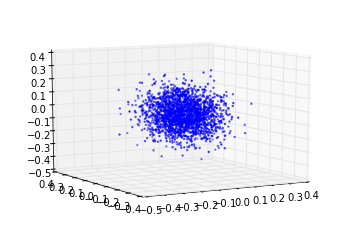

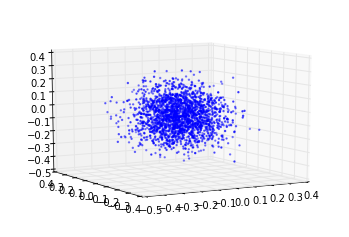

In [13]:
for i in range(10):
    Point_Cloud(gan.generate(1, noise_params)[0]).plot()